(memo)
new lens cavity mesurement for FSR

In [1]:
DATADIR = '../../data/'
LOGDIR = '../../log/'

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import find_peaks
from scipy.optimize import curve_fit 
import os
import pathlib
import datetime
import time
import allantools

# データ取得

In [2]:
class cavity():
    
    def __init__(self, settings = []):
        
        self.settings = settings
        self.DATADIR = DATADIR
        self.lam0 = 852.3 # nm
        self.hyperfine = 9.192 # GHz
        self.neff = 1.454
        
    def load_data(self, runpath):
        fpath = DATADIR+ runpath  +'.dat'
        tag = runpath.split('_')[1]
        # currently same format
        if tag == 'wide':
            data = np.transpose(np.genfromtxt(fpath, dtype=None))
        elif tag == 'zoom' or 'zoom2':
            #print('load zoom file')
            data = np.transpose(np.genfromtxt(fpath, dtype=None))
        self.timestamp = time.ctime(os.path.getmtime(fpath))
        return data

#moving average
def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

#fitting
def gauss(x, H, A, mu, sigma):
    return H + A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def lorentz( x, x0, a, gamma ,b):
    return a * gamma / ( gamma**2 + ( x - x0 )**2) + b

In [45]:
start = 30
finish = 1800
fnum = np.asarray(range(start,finish)) # the number of data

plot_on = False
analyse_on = True
data_ = []

x0_ = []
x1_ = []
o_data = {'cs_1':[], 'cs_2':[], 'pk_1':[], 'pk_2':[]}
analyse_data = {'FSR':[], 'FWHM':[], 'Finesse':[]}

#各dataに対するloop
for i in range(len(fnum)):
    data_sets = {
         '20240518/spec_cav_#'+str(fnum[i]).zfill(4):{'x_range':200}
    }
    for runpath, settings  in sorted(data_sets.items()):
        #50個終わる毎にrunpathを表示
        if np.mod(i, 100) == 0:
            print(runpath) #(runpath, settings)
        dx = settings['x_range']
        fpath = DATADIR+ runpath  +'.dat'
        cav = cavity()
        data = cav.load_data(runpath)

        #channel config
        y0, y1, y2, y3 = np.transpose(data)
        y_cs = y2
        y_cav = y0
        y_ramp = y1

        #range
        #nmin, nmax = np.argmin(y_ramp), np.argmax(y_ramp) # index of max, min
        #nmin = nmin + int((nmax- nmin)*0)
        #nmax = nmax - int((nmax-nmin)*0)
        nmin = 1000
        nmax = 9000

        #moving average
        nmov = 20
        x = np.arange(0,nmax-nmin)
        x_mov = moving_average(x, nmov)
        y_cs_mov = moving_average(y_cs[nmin:nmax], nmov) 
        y_cav_mov = moving_average(y_cav[nmin:nmax], nmov)

        #peak search of Cs
        xr = [0,2000,nmax-nmin]
        a,b = (x_mov>xr[0])&(x_mov<xr[1]), (x_mov>xr[1])&(x_mov<xr[2]) #()内の条件を満たすような範囲からminをsearchする.
        x1, x2 = x_mov[a][np.argmin(y_cs_mov[a])], x_mov[b][np.argmin(y_cs_mov[b])]

        #fitting for Cs
        y_cs_mov_dash = np.max(y_cs_mov)-y_cs_mov 
        
        dx = 500
        xx = np.arange(int(x1)-dx, int(x1)+dx,1) #peak±dxの範囲指定
        parameter_initial = (0, 1, x1, 100) #(H, A, mu, sigma)
        popt, pcov = curve_fit(gauss, xx, y_cs_mov_dash[xx], p0 = parameter_initial, maxfev = 100000)
        estimated_curve = gauss(xx, popt[0], popt[1], popt[2], popt[3])
        o_data['cs_1'].append(popt[2])
        
        xx = np.arange(int(x2)-dx, int(x2)+dx,1) #peak±dxの範囲指定
        parameter_initial = (0, 1, x2, 100) #(H, A, mu, sigma)
        popt, pcov = curve_fit(gauss, xx, y_cs_mov_dash[xx], p0 = parameter_initial, maxfev = 100000)
        estimated_curve = gauss(xx, popt[0], popt[1], popt[2], popt[3])
        o_data['cs_2'].append(popt[2])

        conv = 9192/(o_data["cs_2"][i]-o_data["cs_1"][i])

        #peak search of cavity peak
        peaks, _ = find_peaks(y_cav_mov, height=1)

        #fitting for cav peak 
        for j in range(len(peaks)):
            xx = np.arange(peaks[j]-dx,peaks[j]+dx,1) #peak±dxの範囲指定
            parameter_initial = (peaks[j], 15, 13, 0.1) #(x0, a, gamma )
            popt, pcov = curve_fit(lorentz, xx, y_cav_mov[xx], p0 = parameter_initial, maxfev = 100000)
            estimated_curve = lorentz(xx, popt[0], popt[1], popt[2], popt[3])
            o_data['pk_'+str(j+1)].append(popt[0])

            if analyse_on:
                FWHM = 2*popt[2]*conv
                analyse_data['FWHM'].append(FWHM)
                if plot_on:
                    plt.plot(xx, estimated_curve, color="r")

        if len(peaks) == 2:
            FSR = (o_data["pk_2"][i]-o_data["pk_1"][i])*conv
            analyse_data['FSR'].append(FSR)
            for k in range(len(analyse_data['FWHM'])):
                Finesse = FSR/analyse_data['FWHM'][k]
                analyse_data['Finesse'].append(Finesse)

        if plot_on:
            plt.plot(x_mov, y_cav_mov)
            plt.plot(x_mov, y_cs_mov)
            plt.axvline(x=x1, color="g")
            plt.axvline(x=x2, color="g")

20240518/spec_cav_#0030
20240518/spec_cav_#0130
20240518/spec_cav_#0230
20240518/spec_cav_#0330
20240518/spec_cav_#0430
20240518/spec_cav_#0530
20240518/spec_cav_#0630
20240518/spec_cav_#0730
20240518/spec_cav_#0830
20240518/spec_cav_#0930
20240518/spec_cav_#1030
20240518/spec_cav_#1130
20240518/spec_cav_#1230
20240518/spec_cav_#1330
20240518/spec_cav_#1430
20240518/spec_cav_#1530
20240518/spec_cav_#1630
20240518/spec_cav_#1730


# 確認用コード(for two peaks)

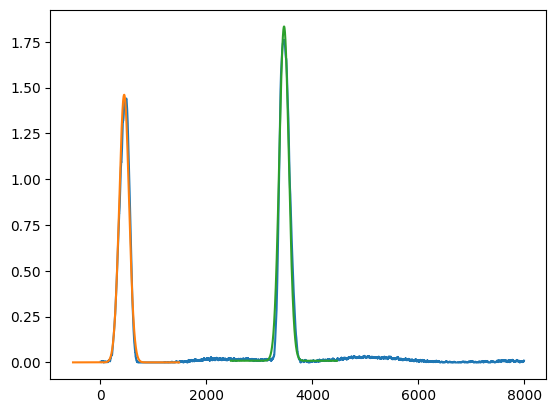

In [12]:
plt.plot(x_mov,y_cs_mov_dash)

xr = [0,3000,8000]
i,j = (x_mov>xr[0])&(x_mov<xr[1]), (x_mov>xr[1])&(x_mov<xr[2]) #()内の条件を満たすような範囲からminをsearchする.
x1, x2 = x_mov[i][np.argmin(y_cs_mov[i])], x_mov[j][np.argmin(y_cs_mov[j])]

dx = 1000

xx = np.arange(int(x1)-dx, int(x1)+dx,1) #peak±dxの範囲指定
parameter_initial = (0, 1, x1, 100) #(H, A, mu, sigma)
popt, pcov = curve_fit(gauss, xx, y_cs_mov_dash[xx], p0 = parameter_initial, maxfev = 100000)
estimated_curve = gauss(xx, popt[0], popt[1], popt[2], popt[3])
plt.plot(xx, gauss(xx, popt[0], popt[1], popt[2], popt[3]))

xx = np.arange(int(x2)-dx, int(x2)+dx,1) #peak±dxの範囲指定
parameter_initial = (0, 1, x2, 100) #(H, A, mu, sigma)
popt, pcov = curve_fit(gauss, xx, y_cs_mov_dash[xx], p0 = parameter_initial, maxfev = 100000)
estimated_curve = gauss(xx, popt[0], popt[1], popt[2], popt[3])
plt.plot(xx, gauss(xx, popt[0], popt[1], popt[2], popt[3]))

FWHM= 95.44021637174487 [MHz]
Finesse= 214.18417286417616


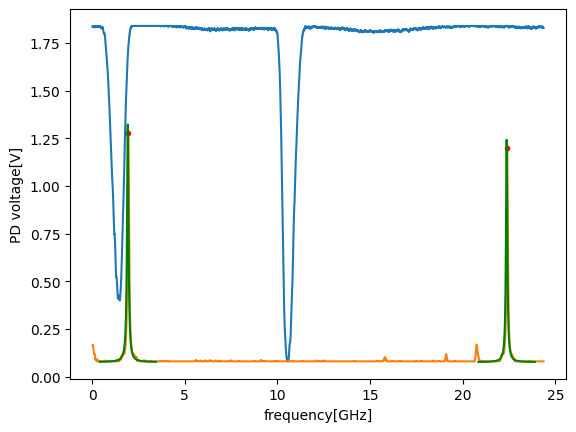

In [16]:
conv = 9.192/(o_data["cs_2"][0]-o_data["cs_1"][0])
plt.plot(x_mov*conv,y_cs_mov)
plt.plot(x_mov*conv,y_cav_mov)
plt.xlabel("frequency[GHz]")
plt.ylabel("PD voltage[V]")

#peak search
peaks, _ = find_peaks(y_cav_mov, height=1, distance=700)
plt.plot(peaks*conv,y_cav_mov[peaks], '.', color="r")

dx = 500
popt_list = []

for i in range(len(peaks)):
    xx = np.arange(peaks[i]-dx,peaks[i]+dx,1) #peak±dxの範囲指定
    parameter_initial = (peaks[i], 1, 10, 0.1) #(x0, a, gamma, b)
    popt, pcov = curve_fit(lorentz, xx, y_cav_mov[xx], p0 = parameter_initial, maxfev = 10000)
    estimated_curve = lorentz(xx, popt[0], popt[1], popt[2], popt[3])
    popt_list.append(popt)
    plt.plot(xx*conv, estimated_curve, color="g")

# FWHM
FWHM = 2*popt_list[0][2]*9192/(o_data["cs_2"][0]-o_data["cs_1"][0])
print("FWHM=",FWHM,"[MHz]")
print("Finesse=",FSR/FWHM)

plt.savefig("Cavity_Plot_TwoPeaks")

# 確認用コード(for one peak)

FWHM= 87.12233644648899 [MHz]


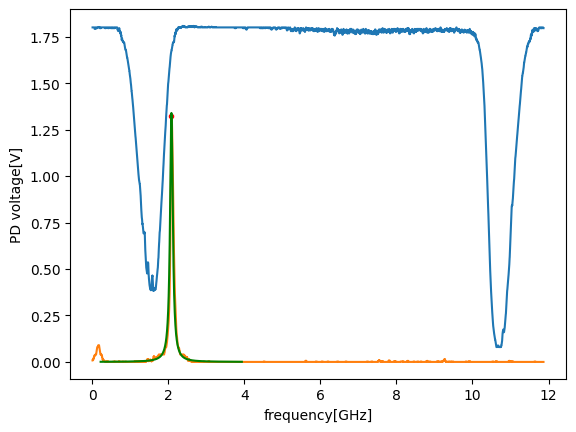

In [24]:
conv = 9.192/(o_data["cs_2"][0]-o_data["cs_1"][0])
plt.plot(x_mov*conv,y_cs_mov)
plt.plot(x_mov*conv,y_cav_mov)
plt.xlabel("frequency[GHz]")
plt.ylabel("PD voltage[V]")

#peak search
peaks, _ = find_peaks(y_cav_mov, height=1, distance=700)
plt.plot(peaks*conv,y_cav_mov[peaks], '.', color="r")

#fitting
dx = 1250
popt_list = []

for i in range(len(peaks)):
    xx = np.arange(peaks[i]-dx,peaks[i]+dx,1) #peak±dxの範囲指定
    parameter_initial = (peaks[i], 40, 30) #(x0, a, gamma )
    popt, pcov = curve_fit(lorentz, xx, y_cav_mov[xx], p0 = parameter_initial, maxfev = 10000)
    estimated_curve = lorentz(xx, popt[0], popt[1], popt[2])
    popt_list.append(popt)
    plt.plot(xx*conv, estimated_curve, color="g")

# FWHM
FWHM = 2*popt_list[0][2]*9192/(o_data["cs_2"][0]-o_data["cs_1"][0])
print("FWHM=",FWHM,"[MHz]")
#print("Finesse=",FSR/FWHM)

#plt.savefig("Cavity_Plot_OnePeak")

# ファイル取得時間

In [46]:
#ファイル保存時間の取得
#時間の単位はsecond

t = []
for i in range(start, finish):
    p = pathlib.Path(DATADIR+'20240518/spec_cav_#'+str(i).zfill(4)+'.dat')
    t.append(os.path.getmtime(p))

#t_:計測開始を0sとしたときの各データの計測時間[s]
t_ = []
for j in range(finish - start):
    a = (t[j] - t[0])
    t_.append(a)

ts = np.asarray(t_)
sec_hour = 60*60.
sec_min = 60.

# plot

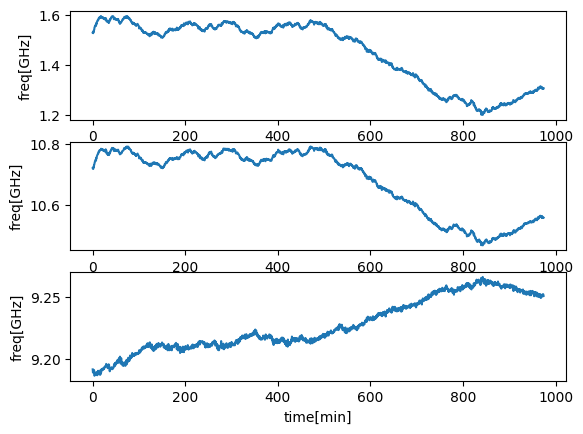

In [58]:
xx = np.arange(1,len(o_data["cs_1"])+1)
plt.subplot(311)
plt.plot(ts/sec_min, (np.array(o_data["cs_1"]))*9.192/(o_data["cs_2"][0]-o_data["cs_1"][0]))
plt.ylabel("freq[GHz]")

plt.subplot(312)
plt.plot(ts/sec_min, (np.array(o_data["cs_2"]))*9.192/(o_data["cs_2"][0]-o_data["cs_1"][0]))
plt.ylabel("freq[GHz]")

plt.subplot(313)
plt.plot(ts/sec_min, (np.array(o_data["cs_2"])-np.array(o_data["cs_1"]))*9.192/(o_data["cs_2"][0]-o_data["cs_1"][0]))
plt.xlabel("time[min]")
plt.ylabel("freq[GHz]")
plt.savefig("Cs")

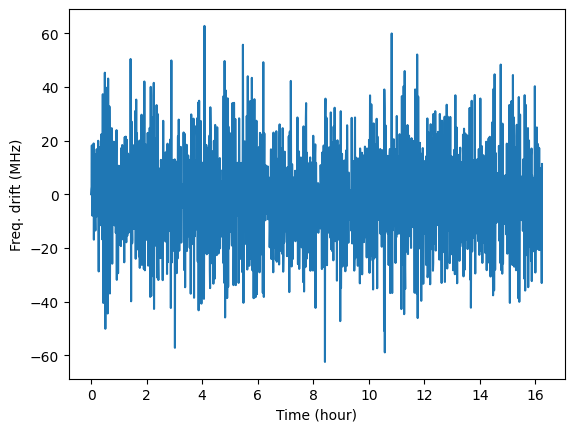

In [57]:
f1 = np.asarray(o_data['pk_1'])
#f2 = np.asarray(o_data['pk_2'])
cs1, cs2 = np.asarray(o_data['cs_1']), np.asarray(o_data['cs_2'])

#csのpeakとの差分で評価する
f1c = f1-cs1
#f2c = f2-cs1
hyp_pxl = cs2-cs1

# conver to MHz
hpf_MHz = 9192 #[MHz]
f1c = f1c/hyp_pxl*hpf_MHz
#f2c = f2c/hyp_pxl*hpf_MHz

#plot
plt.plot(ts/sec_hour, f1c- f1c[0])
plt.ylabel('Freq. drift (MHz)')
plt.xlabel('Time (hour)')
#plt.yticks(np.arange(-100, 125, 25))
plt.savefig("stability")

# Analysis of temperature

In [54]:
#時間読み込み
def date2num(s):
    return datetime.datetime.strptime(s,'\"%Y/%m/%d %H:%M\'%S\"')

#温度・圧力・湿度読み込み
def numstr2num(s):
    #print(s)
    if(len(s)>4):
        bb=float(s[3:-1])
    else: 
        bb=np.nan
    return bb

In [55]:
df = LOGDIR + '20240518/20240518.txt'
tHour=np.array([])
myTemp=np.array([])
myRH=np.array([])
myPress=np.array([])

myDates=np.loadtxt(df,skiprows=4,converters={0: date2num}, delimiter=',',usecols=0,encoding='latin',dtype=object)
myTemp=np.concatenate((myTemp,np.loadtxt(df,skiprows=4,converters={2: numstr2num}, delimiter=',',usecols=2,encoding='latin',dtype=object)))
myRH=np.concatenate((myRH,np.loadtxt(df,skiprows=4,converters={3: numstr2num}, delimiter=',',usecols=3,encoding='latin',dtype=object)))
myPress=np.concatenate((myPress,np.loadtxt(df,skiprows=4,converters={4: numstr2num}, delimiter=',',usecols=4,encoding='latin',dtype=object)))


dt0=myDates[0]
myTime=myDates-dt0
tSecond=np.zeros((len(myTime),))
for i in range(0,len(myTime)):
        tSecond[i]=myTime[i].total_seconds()

tHour=tSecond/60/60

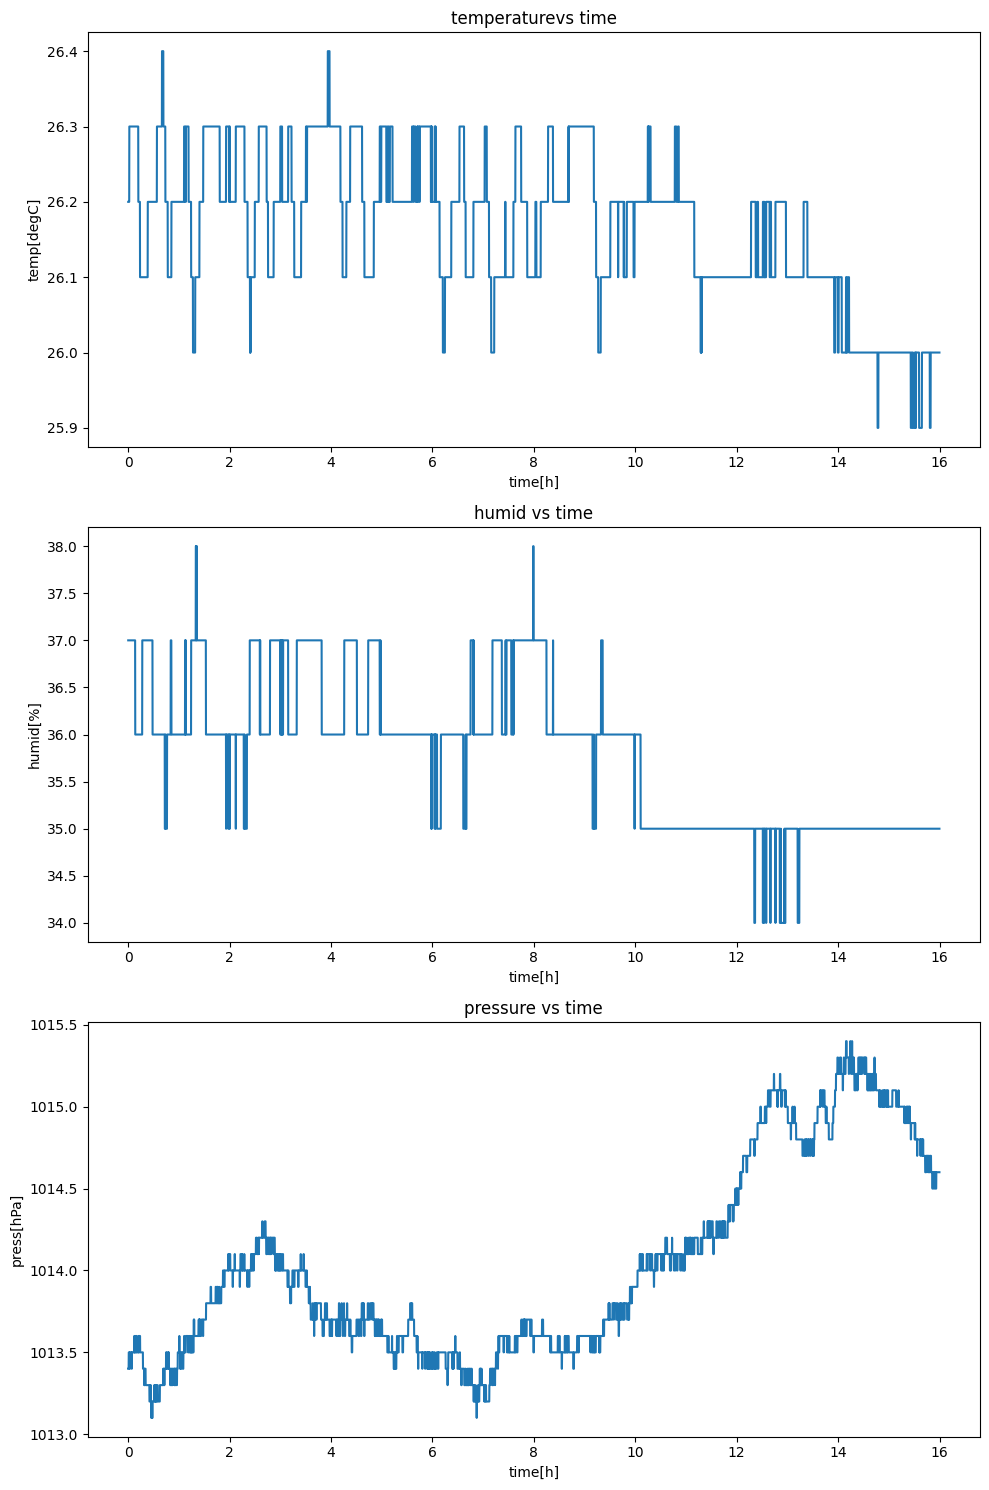

In [56]:
end = 5760
plt.figure(tight_layout=True, figsize=(10,15))

plt.subplot(311, title="temperaturevs time", xlabel="time[h]", ylabel="temp[degC]")
plt.plot(tHour[0:end], myTemp[0:end])

plt.subplot(312, title="humid vs time", xlabel="time[h]", ylabel="humid[%]")
plt.plot(tHour[0:end], myRH[0:end])

plt.subplot(313, title="pressure vs time", xlabel="time[h]", ylabel="press[hPa]")
plt.plot(tHour[0:end], myPress[0:end])

plt.tight_layout()
plt.savefig("environment data")

# Stablity of peak drift

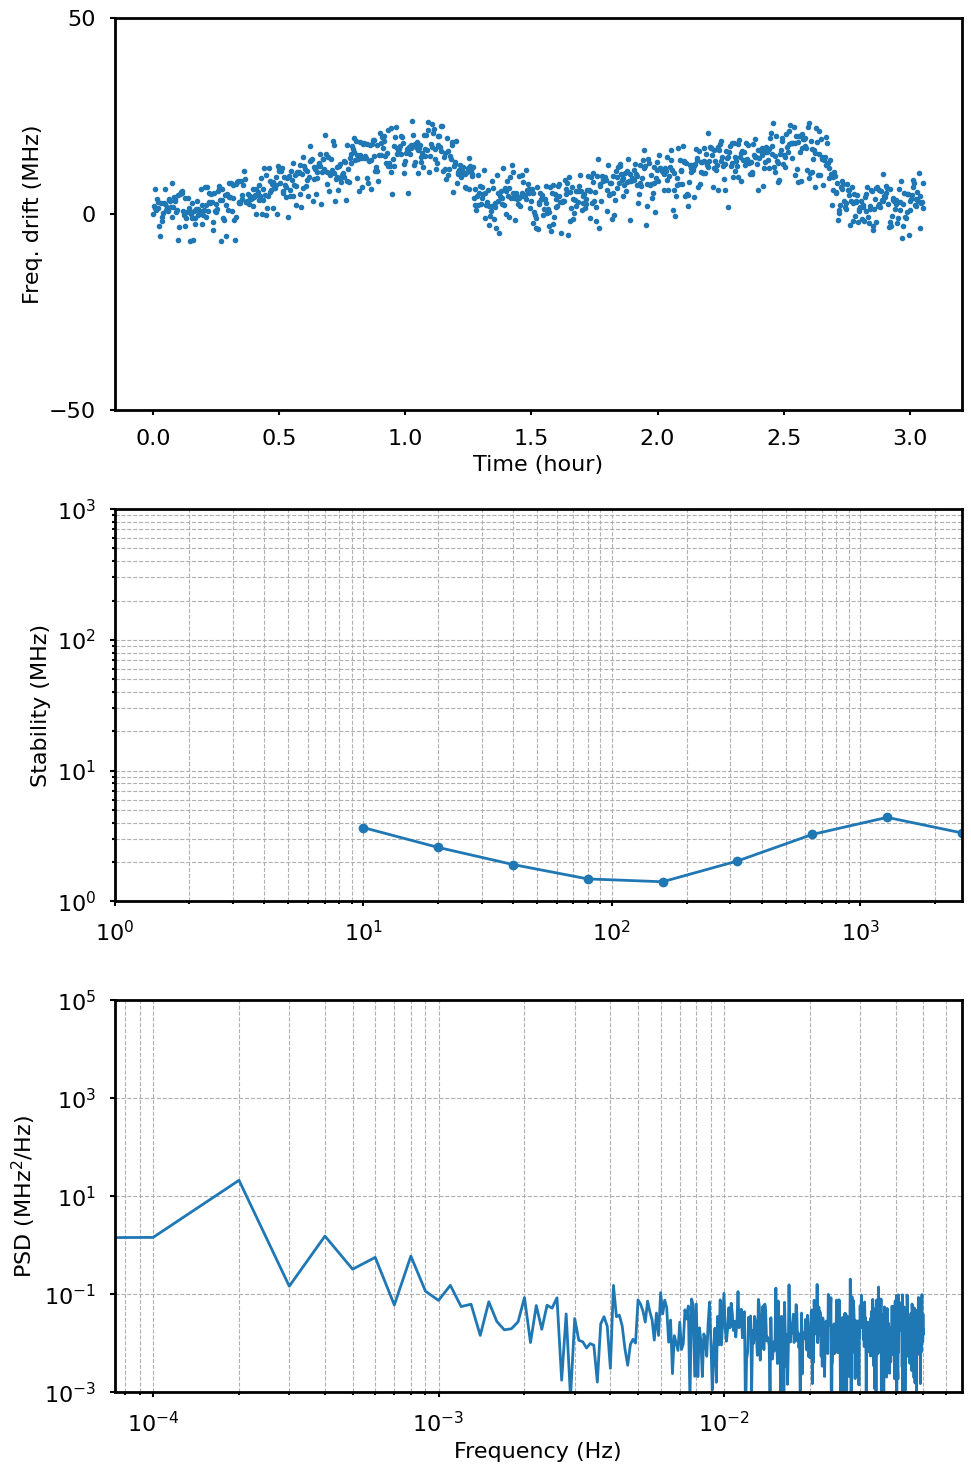

In [20]:
fig, ax = plt.subplots(3)
fig.set_size_inches(10,15)

f1 = np.asarray(o_data['pk_1'])
f2 = np.asarray(o_data['pk_2'])
cs1, cs2 = np.asarray(o_data['cs_1']), np.asarray(o_data['cs_2'])
f1c = f1-cs1
f2c = f2-cs1
hyp_pxl = cs2-cs1
ts = np.asarray(t_)

# conver to MHz
hpfMHz = 9192
f1c = f1c/hyp_pxl*hpfMHz
f2c = f2c/hyp_pxl*hpfMHz
sec2hour = 60*60.

#plot
ax[0].plot(ts/sec2hour, f1c - f1c[0], '.')
ax[0].set_ylabel('Freq. drift (MHz)')
ax[0].set_xlabel('Time (hour)')
ax[0].set_yticks(np.arange(-50, 100, 50))

# # allandev
(taus_used1, adev1, adeverror1, adev_n1) = allantools.oadev(f2c, rate=1./(ts[1]-ts[0]), data_type='freq')
ax[1].plot(taus_used1, adev1, '-o')
ax[1].set_ylabel('Stability (MHz)')
ax[1].set_xlim(1, taus_used1[-1])
ax[1].set_ylim(1, 1e3)
        
# PSD
f, psd = sp.signal.periodogram(f2c, 1./(ts[1]-ts[0]), scaling='spectrum')
ax[2].plot(f, psd)
ax[2].set_ylabel(r'PSD (MHz$^2$/Hz)')
ax[2].set_xlabel('Frequency (Hz)')
        

[ax[i].set_xscale('log') for i in [1,2]]
[ax[i].set_yscale('log') for i in [1,2]]
[ax[i].grid(True, which="both",ls="--") for i in [1,2]]

ax[2].set_ylim(1e-3,1e5)
plt.tight_layout()

#fig.savefig("cavity_drift")

# Correlation between freq drift and various data.

In [31]:
def getNearestValueIndex(list, num):
    #最も値が近い要素のindexを取得
    idx = np.abs(np.array(list) - num).argmin() 
    return idx

def RoundingDown(x,n):
    # x:切り捨てを実行した小数
    # n:小数部分の桁数(>1)
    y = math.floor(x * 10 ** n) / (10 ** n)
    return y
    
from matplotlib.pyplot import xcorr

In [38]:
temp_dash = []

#t_: peak driftのgraphの時間[sec]
#tSecond: tempのgraphの時間[sec]
for i in range(len(t_)):
    id = getNearestValueIndex(tSecond, t_[i])
    temp_dash.append(myTemp[id])

# numpy arrayに変換
temp_dash = np.array(temp_dash)

[-999 -998 -997 ...  997  998  999]


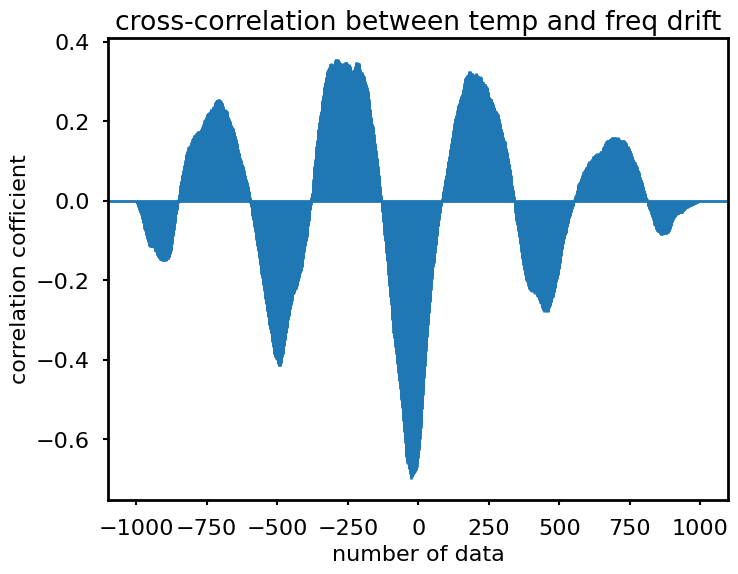

In [41]:
lags, xc_temp, fig, ax = xcorr(temp_dash - sum(temp_dash)/len(temp_dash), f2c-f2c[0] - sum(f2c-f2c[0])/len(f2c-f2c[0]), maxlags=None)
plt.title("cross-correlation between temp and freq drift")
plt.xlabel("number of data")
plt.ylabel("correlation cofficient")

#plt.savefig("CCF_temp")

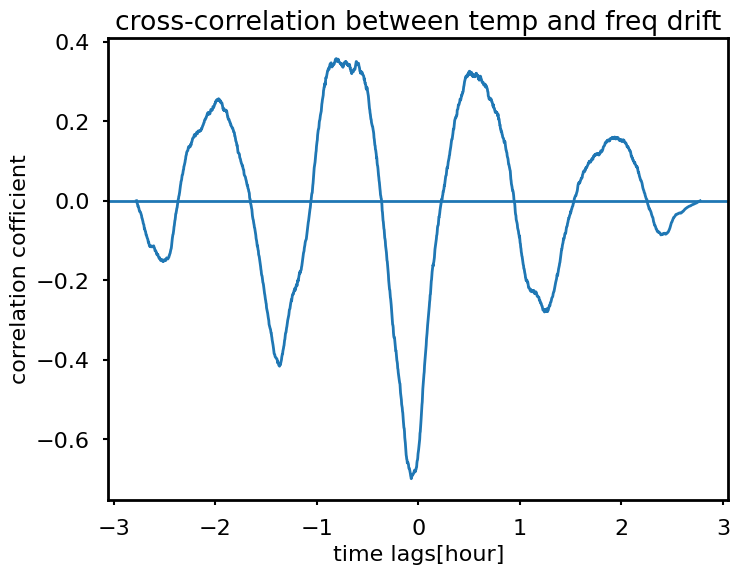

In [47]:
time_lags = lags*10/60/60
plt.plot(time_lags, xc_temp)
plt.title("cross-correlation between temp and freq drift")
plt.xticks(np.arange(-3,4,1))
plt.xlabel("time lags[hour]")
plt.ylabel("correlation cofficient")
plt.axhline(y=0)

plt.savefig("CCF_temp_time")